<a href="https://colab.research.google.com/github/upriyam-cmu/EDGE-Rec/blob/main/execute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install project code

In [1]:
!pip uninstall -y edge-rec
!pip install -e.

Found existing installation: edge-rec 0.0.0
Uninstalling edge-rec-0.0.0:
  Successfully uninstalled edge-rec-0.0.0
Obtaining file:///home/ec2-user/code/EDGE-Rec
  Preparing metadata (setup.py) ... done
  Running setup.py develop for edge-rec


# Train model

In [38]:
from edge_rec.gaussian_diffusion import GaussianDiffusion, Trainer
from edge_rec.model import GraphReconstructionModel

results_folder = "./results" # Replace this to load trained models

model = GraphReconstructionModel.default()

diffusion_model = GaussianDiffusion(model, image_size=50)
trainer = Trainer(
    diffusion_model, folder="./movie_lens", train_num_steps=int(1e4),
    use_alternate_dense_dataset=True, save_and_sample_every=1000,
    train_on_binary_targets=False,
    train_mask_unknown_ratings=False,
    alternate_dense_dataset_density=0.7,
    results_folder=results_folder
    # If the patch_size is large:
    # train_batch_size=8,
    # gradient_accumulate_every=2,
)
print("Using device:", trainer.device)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


Using device: cuda


In [3]:
print("num params:", sum(param.numel() for param in model.parameters()))

num params: 415758


In [16]:
trainer.train()

100%|##########| 30000/30000.0 [00:00<?, ?it/s]

training complete


# Sample ratings

In [3]:
d70_subgraph, train_ratings, test_ratings = trainer.ds.dataset.get_subgraph(
    subgraph_size=50,
    target_density=0.5,
    include_separate_train_test_ratings=True,
)
d70_subgraph = d70_subgraph[:-1]
sampled_ratings = trainer.eval(milestone=5000, full_graph=d70_subgraph, subgraph_size=80)[0, 0, :, :].cpu().detach()
sampled_ratings = (sampled_ratings-0.2) * 2.5 + 3

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
sampled_ratings.max()

tensor(5.)

In [4]:
import torch
import pandas as pd
from edge_rec.evaluate import get_metrics

torch.manual_seed(1000)
iters = 30
density = 0.5
patch_size = 50
for milestone in [10000]:
    sampled_metrics = 0
    random_metrics = 0
    for iter in range(iters):
        d70_subgraph, train_ratings, test_ratings = trainer.ds.dataset.get_subgraph(
        subgraph_size=patch_size,
        target_density=density,
        include_separate_train_test_ratings=True
        )
        d70_subgraph = d70_subgraph[:-1]
        sampled_ratings = trainer.eval(milestone=milestone, full_graph=d70_subgraph, subgraph_size=patch_size)[0, 0, :, :].cpu().detach()
        sampled_ratings = (sampled_ratings-0.2) * 2.5 + 3

        random_ratings = torch.rand(sampled_ratings.shape) * 5

        train_edges = train_ratings.long().to_sparse_coo()
        train_edges = torch.cat([
            train_edges.indices(),
            train_edges.values().unsqueeze(dim=0)
        ], dim=0)
        test_edges = test_ratings.long().to_sparse_coo()
        test_edges = torch.cat([
            test_edges.indices(),
            test_edges.values().unsqueeze(dim=0)
        ], dim=0)

        metrics = pd.DataFrame(get_metrics(train_edges, test_edges, sampled_ratings))
        sampled_metrics = sampled_metrics + metrics
        random_metrics = random_metrics + pd.DataFrame(get_metrics(train_edges, test_edges, random_ratings))

    avg_sampled_metrics, avg_random_metrics = sampled_metrics / iters, random_metrics / iters
    avg_sampled_metrics.to_csv(f"metrics/avg_sampled_metrics_patch_size_{patch_size}_density_{density}_milestone_{milestone}.csv")

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

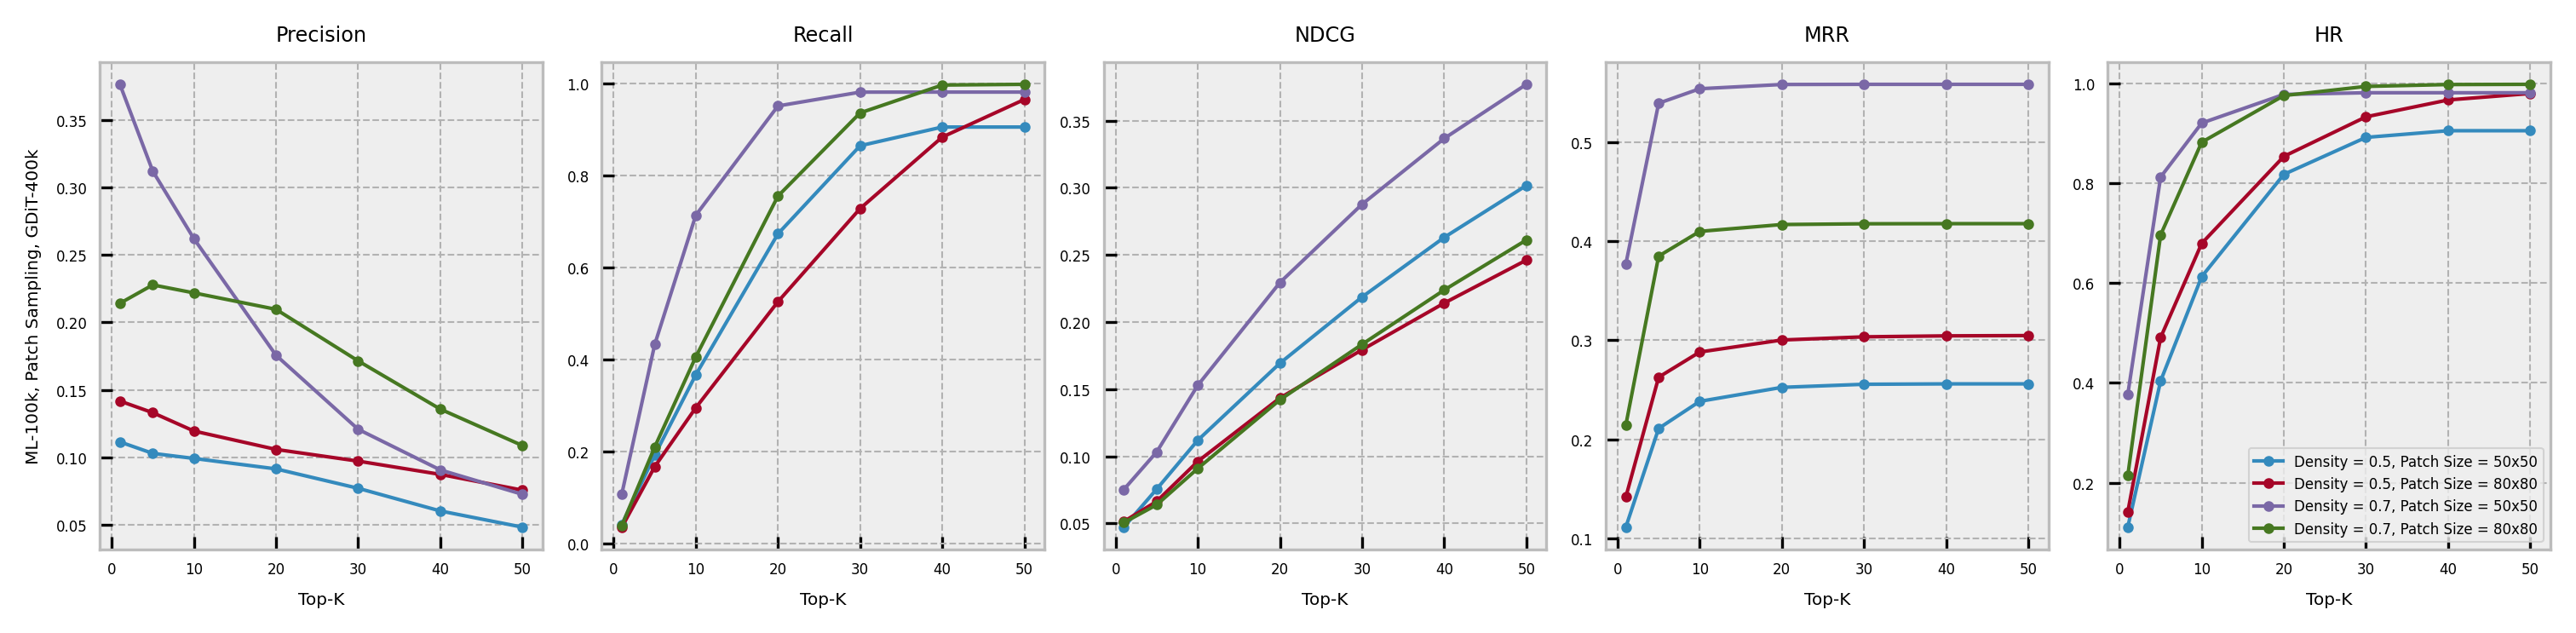

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

mpl.rcParams.update({'figure.dpi': 300, 'font.size': 4})
plt.style.use('bmh')
fig, axs = plt.subplots(1,5, figsize=[10, 2.4])
ks = (1, 5, 10, 20, 30, 40, 50)

for density in [0.5, 0.7]:
    for patch_size in [50, 80]:
        d = pd.read_csv(f"metrics/avg_sampled_metrics_patch_size_{patch_size}_density_{density}_milestone_10000.csv")
        for ax, name, alias in zip(axs, ['precision', 'recall', 'ndcg', 'mean_reciprocal_rank', 'hit_rate'], ['Precision', 'Recall', 'NDCG', 'MRR', 'HR']):
            ax.set_title(alias)
            ax.xaxis.grid(True, which='major')
            ax.xaxis.set_major_locator(MultipleLocator(10))
            ax.xaxis.set_major_formatter('{x:.0f}')
            ax.plot(ks, d[name], '.-', linewidth=1.0, markersize=4.0, label=f"Density = {density}, Patch Size = {patch_size}x{patch_size}")
            if name == 'precision':
                ax.set_ylabel("ML-100k, Patch Sampling, GDiT-400k")
            elif name == 'hit_rate':
                ax.legend()
            ax.set_xlabel("Top-K")
            #ax.set_aspect(50 / (d[name].max() - d[name].min()))

plt.tight_layout(h_pad=-25.0)
plt.savefig("ml100k_large_model_results.png")

# Evaluate metrics

In [53]:
from edge_rec.evaluate import get_metrics
import torch

train_edges = train_ratings.long().to_sparse_coo()
train_edges = torch.cat([
    train_edges.indices(),
    train_edges.values().unsqueeze(dim=0)
], dim=0)
test_edges = test_ratings.long().to_sparse_coo()
test_edges = torch.cat([
    test_edges.indices(),
    test_edges.values().unsqueeze(dim=0)
], dim=0)

get_metrics(train_edges, test_edges, sampled_ratings)

{'precision': tensor([0.2200, 0.2360, 0.2300, 0.1580, 0.1140, 0.0855, 0.0684]),
 'recall': tensor([0.0790, 0.3545, 0.6948, 0.9170, 0.9800, 0.9800, 0.9800]),
 'mean_reciprocal_rank': tensor([0.2200, 0.3927, 0.4262, 0.4276, 0.4276, 0.4276, 0.4276]),
 'hit_rate': tensor([0.2200, 0.7200, 0.9600, 0.9800, 0.9800, 0.9800, 0.9800]),
 'ndcg': tensor([0.0510, 0.0425, 0.0873, 0.1703, 0.2256, 0.2818, 0.3318])}

# Display sampled ratings distribution

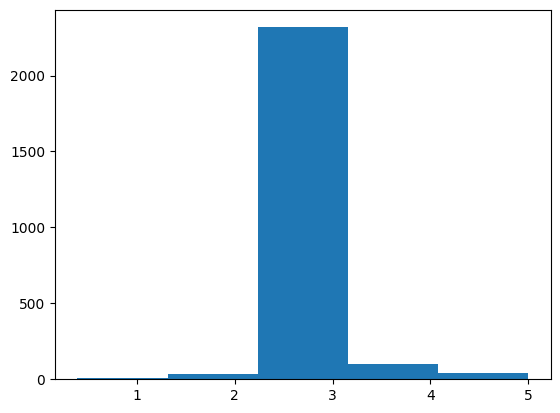

In [44]:
import matplotlib.pyplot as plt

plt.hist(sampled_ratings.numpy().flatten(), bins=5)
plt.show()